In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Warstwy - opisy i prosta implementacja konwolucji 

#### Konwolucja

Warstwa konwolucyjna służy jako główne narzędzie do wyciągania cech z wejściowych obrazów. Wykorzystuje ona trzy pojęcia, które mogą polepszyć nasz model - zarówno pod kątem jakości predykcji, jak i szybkości uczenia. Sa to:
* rzadkie oddziaływania (*sparse interactions*) - połączenia między kolejnymi warstwami nie występują pomiędzy każdym neuronem - każdy piksel wpływa tylko na pewne otoczenie kolejnej warstwy parametrów,
* współdzielenie parametrów - wielokrotnie stosujemy te same wagi na różnych częściach obrazka. Sprawia to, że model potrzebuje dużo mniej parametrów aby przekazać podobną ilość istotnych informacji,
* ekwiwariancja względem translacji - jeżeli przesuniemy nasz obrazek o pewną ilość pikseli, to samo przesunięcie zaobserwujemy na warstwie wyjściowej.



#### Wizualizacja działania

![](img/convolve.png)

#### Istotne parametry
* ilość filtrów
* szerokość filtra - tutaj im większa wartość, tym bardziej skomplikowane zalezności jest w stanie wykryć filtr - ale kosztem większej złożoności pamięciowej i obliczeniowej. Na ogół używa się 3 lub 5, aczkolwiek ciekawostka - przydatne bywają też filtry 1x1 (o tym później)
* *stride* - o ile pikseli przesuwany jest filtr w każdym kroku. Domyślnie 1, większe wartości powodują zmniejszenie wyjścowego obrazka
* *padding* - rozszerzenie obrazka wejściowego tak, aby wyjściowy miał te same wymiary.  


In [2]:
def conv_forward(X, W):
    """
    Funkcja oblicza forward pass dla warstwy konwolucyjnej. Parametry:
    X - tensor wejściowy. Wymiary: [wysokość, szerokość, ilość kanałów]
    W - tensor reprezentujący zestaw filtrów. Wymiary: [ilość filtrów, wysokość, szerokość, głębokość]
    
    Ważne - ilość kanałów wejścia musi być równa głębokości każdego filtru.
    
    Wyjście:
    output - tensor o wymiarach [wysokość, szerokość, ilość filtrów]
    cache - krotka (X,W)- potrzebna do propagacji wstecznej
    """
    
    # wyciągnięcie wymiarów
    try:
        heigth, width, depth = X.shape
        num_filters, W_heigth, W_width, W_depth = W.shape
        assert(depth == W_depth)
    except Exception as e:
        print ('Dimension error!')
        print (X.shape, W.shape)
        raise(Exception)
        
    # obliczenie paddingu
    padding = (W_heigth-1)//2
    
    ## rozszerzamy obrazek tak, aby output miał te same wymiary co X
    X_to_process = np.pad(X, ((padding,padding), (padding,padding), (0,0)), 'edge')
    
    output = np.zeros((heigth, width, num_filters))
    
    # super nieoptymalna implementacja z potrójną pętlą
    for i in range(heigth):
        for j in range(width):
            for k in range(num_filters):
                output[i,j,k] = np.sum(
                    X_to_process[i:(i+W_heigth), j:(j+W_heigth), :] * W[k]
                )
    
    return output, (X, W)    

def conv_backward(dO, cache):
    """
    Funkcja oblicza forward pass dla warstwy konwolucyjnej. Parametry:
    dO - tensor wejściowy reprezentujący wartości pochodnej funkcji straty po aktywacjach warstwy wyjściowej. 
         Wymiary: [wysokość, szerokość, ilość kanałów]
    cache - Krotka zawierająca cache z forward passu.
        
    Wyjście:
    dW - tensor pochodnych po wartościach filtra
    dX - tensor pochodnych po wartościach wejścia 
    """
    
    (X, W) = cache
    
    try:
        heigth, width, depth = X.shape
        num_filters, W_heigth, W_width, W_depth = W.shape
    except:
        print ('Dimension error!')
        
    
    padding = (W_heigth-1)//2
    
    dX = np.zeros(X.shape)
    dX = np.pad(dX, ((padding,padding), (padding,padding), (0,0)), 'constant')
    dW = np.zeros(W.shape)
    
    X_padded = np.pad(X, ((padding,padding), (padding,padding), (0,0)), 'constant')
    
    for i in range(heigth):
        for j in range(width):            
            for k in range(num_filters):
                for l in range(depth):
                    
                    # każdy filtr wpływa na wyjście wiele razy - za każdym razem proporcjonalnie
                    # do określonego wycinka macierzy X
                    dW[k, :, :, l] += X_padded[i:i+W_heigth, j:j+W_width, l] * dO[i,j, k]
                    
                    # podobnie jak wyżej - każdy 'piksel' wpływa na kilka neuronów wyjściowych - 
                    # proporcjonalnie do wartości wag w  filtrze
                    dX[i:i+W_heigth, j:j+W_width, l] += W[k,:,:,l] * dO[i,j, k]
                    
    return dW, dX[1:(heigth+1), 1:(width+1), :]
            

### Pooling

"The pooling operation used in convolutional neural networks is a big mistake and the fact that it works so well is a disaster." - Geoffrey Hinton

Pooling jest operacją mającą na celu zmniejszenie wymiarowości warstwy przy jednoczesnym zachowaniu jak największej ilości informacji. Stosuje się głównie dwa rodzaje poolingu - *max pooling* i *average pooling*. Nazwy mówią same za siebie - każda z tych operacji przechodzi po obrazku i przeprowadza odpowiednią agregację na jego segmentach. 

#### Wizualizacja

![](img/pooling.JPG)

Jeśli chodzi o propagację gradientu, to zasada działania jest prosta - w przypadku *average poolingu* gradient jest propagowany po równo na każdy piksel w małym segmencie. Dla *max poolingu* cały gradient przechodzi na ten piksel, który miał w warstwie wejściowej maksymalną wartość.  
**TODO**: zaimplementować `max_pool_forward(X)` i `max_pool_backward(dO, cache)`

### Dropout

*Dropout* jest operacją która nie jest specyficzna dla sieci konwolucyjnych, lecz jest ogólnie użyteczna. Rozwiązuje ona problem przeuczania się modelu - sytuacji, w której model uczy się konkretnych obserwacji w zbiorze treningowym, a nie ogólnych cech wpływających na predykowaną cechę.  
W warstwie *dropout* w każdej iteracji uczenia "wyłączony" zostaje pewien odsetek neuronów. Dzięki temu niemożliwe jest na przykład wyuczenie neuronów pod konkretne przypadki. Można myśleć o *dropoucie* jako o pewnego rodzaju komitecie klasyfikatorów - przy uczeniu każda iteracja korzysta z innych cech, a podczas predykcji dostajemy uśrednienie wyników.  
Słowo uśrednienie jest tutaj wstawione celowo - aby zachować podobny rozkład aktywacji neuronów, podczas predykcji nie wyłączamy jednostek, ale za to mnożymy każdą aktywacją przez wcześniejsze prawdopodobieństwo wyłączenia neuronu. 
**TODO: zaimplementować `dropout(X, is_training)`

#### Wizualizacja

![](img/dropout.png)

### Batch normalization

Z poprzednich zajeć powinniśmy pamiętać potencjalne problemy związane z uczeniem sieci na surowych, nieznormalizowanych danych. Wtedy odpowiedzią na to była modyfikacja danych wejściowych. Skąd mamy jednak mieć pewność, że w trakcie uczenia podobna sytuacja nie pojawi się w środku sieci? W skutek wielu przekształceń mogą nam się zacząć pojawiać bardzo duże wartości aktywacji - a to doprowadzi to "wybuchu" w kolejnych warstwach.  

Możemy próbować normalizować wyjście z każdej warstwy osobno - model uczymy w mini-batchach, więc możemy bez problemu liczyć stosowne agregacje. Co jednak zrobić na podczas predykcji, kiedy dostajemy jedną obserwację? Tutaj zwykła normalizacja nie pomoże.  

Rozwiązaniem jest zapamiętywanie średniej i odchylenia standardowego podczas uczenia, i normalizacja tymi wartościami podczas predykcji.

## Keras

Dziś poznamy API funkcyjne Kerasa - narzędzie które pozwala na dużo większą swobodę podczas tworzenia modeli. Szczególnie przydatną cechą jest możliwość zbudowania nowego modelu współdzielącego warstwy z poprzednim - będziemy tego używać przy wizualizacji.

In [3]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Input, Reshape
from keras.utils import to_categorical

### Mnist - przykład

In [4]:
from keras.datasets import mnist
(X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = mnist.load_data()
print(X_train_mnist.shape)
print(Y_train_mnist.shape)

(60000, 28, 28)
(60000,)


In [5]:
# skalowanie min-max - najprostsze
X_train_mnist_scaled = X_train_mnist/255.0
X_test_mnist_scaled = X_test_mnist/255.0

# obrazki w MNIST są w odcieniach szarości, ale
# warstwy konwolucyjne wymagają 4 wymiarów - stąd
# dodanie wymiaru reprezentującego nasz jeden kanał
X_train_mnist_reshaped = X_train_mnist_scaled[:,:,:,np.newaxis]
X_test_mnist_reshaped = X_test_mnist_scaled[:,:,:,np.newaxis]

Tym razem zaczynamy budowę modelu od stworzenia grafu obliczeniowego, który określi kolejne działania na naszych danych. Każda obiekt reprezentujący warstwę traktujemy jako funkcję - i używamy jej do przekształcenia poprzednich warstw.  

Dwie konwencje:
```
x = Input(shape=(,))
x = Dense(20)(x)
x = Dense(10)(x)
output = Dense(1)(x)

```

oraz  
```
x = Input(shape=(,))
x1 = Dense(20)(x)
x2 = Dense(10)(x1)
output = Dense(1)(x2)

```

Obie są poprawne, i obie zachowują pełną strukturę modelu. Druga pozwala jednak na  szybkie odwoływanie się do poszczególnych kroków modelu.

`Input` to tzw. *placegholder* - jest to deklaracja tego, że w tym miejscu będziemy w trakcie obliczeń wrzucać tensory wejściowe. Dzięki deklaracji wymiarów Keras wie, jakich wymiarów powinny być kolejne warstwy.

In [6]:
input_ = Input(shape=(28,28,1))

Dalej używamy warstw Conv2D i MaxPooling2D. Implementują one algorytmy omówione wcześniej.

In [7]:
conv1 = Conv2D(3, (3,3), padding='same', activation='relu')(input_) #28X28
pool1 = MaxPooling2D((2,2), padding='same')(conv1) # 14x14
conv2 = Conv2D(4, (3,3), padding='same', activation='relu')(pool1) #14X14
pool2 = MaxPooling2D((2,2), padding='same')(conv2) # 7x7

Po zakończeniu warstw konwolucyjnych przechodzimy na zwykłą warstwę `Dense`. Przedtem musimy jeszcze 'spłaszczyć' wyjście z ostatniej warstwy konwolucyjnej. Do tego służy warstwa `Reshape`.

In [8]:
reshape = Reshape((7*7*4,))(pool2)
output = Dense(10, activation='softmax')(reshape)

Mając zdefiniowany graf obliczeniowy możemy zdefiniować nasz model. Korzystając z API funkcyjnego używamy klasy `Model` i podajemy tensory wejściowe i wyjściowe. Tak, można używać kilku inputów i kilku outputów.

In [9]:
model_keras = Model(inputs=input_, outputs=output)

# model kompilujemy tak jak wcześniej
model_keras.compile(optimizer="adam", loss="categorical_crossentropy")

In [10]:
model_keras.fit(X_train_mnist_reshaped, to_categorical(Y_train_mnist), epochs=5, batch_size=32, verbose=1)

Epoch 1/5
60000/60000 [==============================] - 10s - loss: 0.3984    
Epoch 2/5
60000/60000 [==============================] - 9s - loss: 0.1555     
Epoch 3/5
60000/60000 [==============================] - 9s - loss: 0.1177     
Epoch 4/5
60000/60000 [==============================] - 9s - loss: 0.1031     
Epoch 5/5
60000/60000 [==============================] - 9s - loss: 0.0948     


In [11]:
preds_mnist = model_keras.predict(X_test_mnist_reshaped)
print('test accuracy: %.2f' % (np.mean(np.argmax(preds_mnist, axis=1) == Y_test_mnist)))

test accuracy: 0.97


### Image augmentation

W przypadku zbiorów niezbyt dużych warto w jakiś sposób zwiększyć ilość różnych obserwacji w zbiorze treningowym. O ile w przypadku danych tabularnych ciężko określić sensowny sposób generacji danych, tak w przypadku obrazków sytuacja wygląda prościej. Jeżeli delikatnie obrócimy cyfrę 1, wciąż jest ona tą samą cyfrą - ale reprezentuje ją już inna macierz. Dzięki temu możemy wygenerować nieskończenie wiele różnych obserwacji, a dodatkowym efektem jest  zwiększenie zdolności modelu do generalizacji. 

W Kerasie możemy użyć generatora, który będzie automatycznie przeprowadzał odpowiednie operacje. 

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from  sklearn.model_selection import train_test_split

In [13]:
data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=0.1
)

In [14]:
X_train_gen, X_val_gen, y_train_gen, y_val_gen = train_test_split(
    X_train_mnist_reshaped, 
    Y_train_mnist, 
    test_size=0.2
)

In [15]:
input_ = Input(shape=(28,28,1))
conv1 = Conv2D(3, (3,3), padding='same', activation='relu')(input_) #28X28
pool1 = MaxPooling2D((2,2), padding='same')(conv1) # 14x14
conv2 = Conv2D(4, (3,3), padding='same', activation='relu')(pool1) #14X14
pool2 = MaxPooling2D((2,2), padding='same')(conv2) # 7x7
reshape = Reshape((7*7*4,))(pool2)
output = Dense(10, activation='softmax')(reshape)

model_keras_generator = Model(inputs=input_, outputs=output)

model_keras_generator.compile(optimizer="adam", loss="categorical_crossentropy")

In [16]:
model_keras_generator.fit_generator(
    generator=data_generator.flow(X_train_gen, to_categorical(y_train_gen), batch_size=32),
    epochs=5,
    steps_per_epoch=X_train_gen.shape[0]//32,
    validation_data=[X_val_gen, to_categorical(y_val_gen)]    
)

Epoch 1/5
1500/1500 [==============================] - 11s - loss: 0.7450 - val_loss: 0.1878
Epoch 2/5
1500/1500 [==============================] - 11s - loss: 0.3716 - val_loss: 0.1697
Epoch 3/5
1500/1500 [==============================] - 10s - loss: 0.3340 - val_loss: 0.1549
Epoch 4/5
1500/1500 [==============================] - 11s - loss: 0.3143 - val_loss: 0.1509
Epoch 5/5
1500/1500 [==============================] - 11s - loss: 0.3069 - val_loss: 0.1469


Widać, że funkcja straty na zbiorze treningowym ma większe wartości niż wcześniej - model musi pomieścić więcej informacji niż wcześniej, aby wziąć pod uwagę wszystkie możliwe transformacje.

### Powtórne używanie warstw w API funkcyjnym

Dzięki współdzieleniu warstw między modelami możemy bardzo łatwo sprawdzić jak wyglądał nasz obrazek wejściowy po przekształceniu przez kolejne warstwy. Możemy w tym momencie zdefiniować nowe modele, używając odniesień do wcześniej zdefiniowanych warstw. Co ważne, używamy już wytrenowanych warstw.

In [17]:
model_after_conv1 = Model(inputs=input_, outputs=pool1)
model_after_conv2 = Model(inputs=input_, outputs=pool2)

In [18]:
def plot_activations_bw(x, model, max_plots=5):
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    n_outputs = prediction.shape[2]
    
    plt.figure()
    for i in range(min(max_plots, n_outputs)):
        plt.imshow(prediction[:,:,i], interpolation = "nearest", cmap = "gray")
        plt.show()


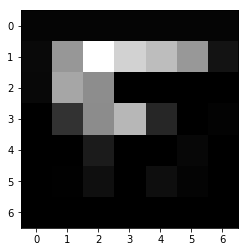

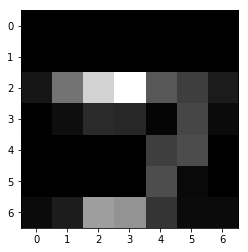

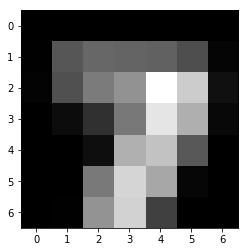

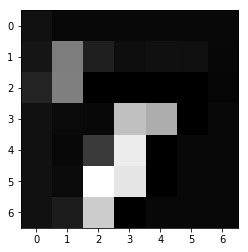

In [19]:
plot_activations_bw(X_test_mnist_reshaped[0], model_after_conv2)

In [20]:
def plot_layers(model, layer_number, max_plots=4):
    weights = model.layers[layer_number].get_weights()[0]
    no_filters = weights.shape[3]
    for i in range(min(no_filters, max_plots)):
        plt.imshow(weights[:,:,0,i], interpolation = "nearest", cmap = "gray")
        plt.show()

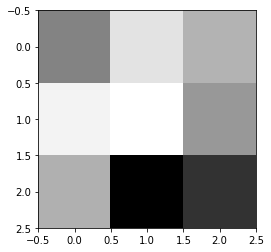

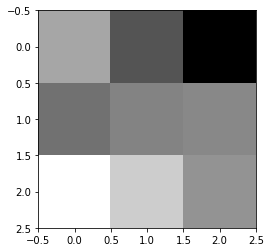

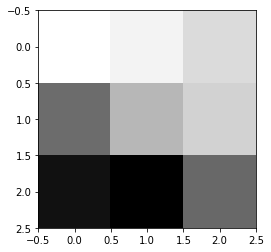

In [21]:
plot_layers(model_keras, 1)

### Cifar

Cifar to trochę bardziej skomplikowany zbiór - zawiera zdjęcia rzeczywistych obiektów należące do 10 klas (wersja CIFAR10). Wersja dostępna w Kerasie jest tylko pewnym wycinkiem całego zbioru.  
Więcej info: https://www.cs.toronto.edu/~kriz/cifar.html

In [22]:
from keras.datasets import cifar10

(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()

In [23]:
X_train_cifar = X_train_cifar/255.0
X_test_cifar = X_test_cifar/255.0

In [24]:
X_train_cifar.shape, y_train_cifar.shape

((50000, 32, 32, 3), (50000, 1))

[1]


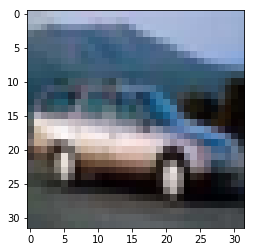

In [25]:
example_img = X_train_cifar[4]
print(y_train_cifar[4])
plt.imshow(example_img, interpolation = "nearest")
plt.show()

In [26]:
input_ = Input(shape=(32,32,3))
conv1 = Conv2D(40, (3,3), padding='same', activation='relu')(input_) #32x32
pool1 = MaxPooling2D((2,2), padding='same')(conv1) # 16x16
conv2 = Conv2D(60, (3,3), padding='same', activation='relu')(pool1) #16x16
pool2 = MaxPooling2D((2,2), padding='same')(conv2) # 8x8
reshape = Reshape((8*8*60,))(pool2)
dense = Dense(200, activation='relu')(reshape)
output = Dense(10, activation='softmax')(dense)
model_cifar = Model(inputs=input_, outputs=output)

In [27]:
model_cifar.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

W przypadku modeli o bardzo dużej ilości hiperparametrów występuje spore ryzyko przeuczenia się. Dlatego bardzo często stosuje się uczenie z jednoczesną walidacją na części zbioru treningowego. Dzięki temu możemy na bieżąco monitorować performance modelu i przerwać uczenie, gdy wyniki na części walidacyjnej zaczynają się pogarszać.

In [28]:
model_cifar.fit(
    X_train_cifar, 
    to_categorical(y_train_cifar),
    validation_split=0.25,
    epochs=5, batch_size=32, verbose=1)

Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s - loss: 1.4276 - acc: 0.4871 - val_loss: 1.1626 - val_acc: 0.5926
Epoch 2/5
37500/37500 [==============================] - 9s - loss: 1.0447 - acc: 0.6318 - val_loss: 1.0778 - val_acc: 0.6202
Epoch 3/5
37500/37500 [==============================] - 9s - loss: 0.8859 - acc: 0.6895 - val_loss: 0.9365 - val_acc: 0.6764
Epoch 4/5
37500/37500 [==============================] - 9s - loss: 0.7678 - acc: 0.7303 - val_loss: 0.9330 - val_acc: 0.6789
Epoch 5/5
37500/37500 [==============================] - 9s - loss: 0.6541 - acc: 0.7692 - val_loss: 0.8910 - val_acc: 0.6932


In [29]:
preds_cifar = model_cifar.predict(X_test_cifar)
print('test accuracy: %.2f' % (np.mean(np.argmax(preds_cifar, axis=1).reshape(y_test_cifar.shape) == y_test_cifar)))

test accuracy: 0.69


In [30]:
# TODO: play with it

Zajawki:
* autoencodery
* GANy